In [24]:
# import bibliotek
import pandas as pd
import numpy as np
from tabulate import tabulate

import utils as u
import seaborn as sns
import matplotlib.pyplot as plt

# from sklearn.impute import KNNImputer
# from sklearn.preprocessing import OneHotEncoder, StandardScaler

In [31]:
df_freq = pd.read_csv("./data/freMTPL2freq.csv")
df_freq["VehPower"] = df_freq["VehPower"].astype("category")

In [32]:
# Przegląd danych
df_freq.head()

,IDpol,ClaimNb,Exposure,Area,VehPower,VehAge,DrivAge,BonusMalus,VehBrand,VehGas,Density,Region
0,1.0,1,0.10,D,5,0,55,50,B12,Regular,1217,R82
1,3.0,1,0.77,D,5,0,55,50,B12,Regular,1217,R82
2,5.0,1,0.75,B,6,2,52,50,B12,Diesel,54,R22
3,10.0,1,0.09,B,7,0,46,50,B12,Diesel,76,R72
4,11.0,1,0.84,B,7,0,46,50,B12,Diesel,76,R72


In [33]:
# Szczegóły danych
df_freq.describe()

,IDpol,ClaimNb,Exposure,VehAge,DrivAge,BonusMalus,Density
count,6.780130e+05,678013.000000,678013.000000,678013.000000,678013.000000,678013.000000,678013.000000
mean,2.621857e+06,0.053247,0.528750,7.044265,45.499122,59.761502,1792.422405
std,1.641783e+06,0.240117,0.364442,5.666232,14.137444,15.636658,3958.646564
min,1.000000e+00,0.000000,0.002732,0.000000,18.000000,50.000000,1.000000
25%,1.157951e+06,0.000000,0.180000,2.000000,34.000000,50.000000,92.000000
50%,2.272152e+06,0.000000,0.490000,6.000000,44.000000,50.000000,393.000000
75%,4.046274e+06,0.000000,0.990000,11.000000,55.000000,64.000000,1658.000000
max,6.114330e+06,16.000000,2.010000,100.000000,100.000000,230.000000,27000.000000


In [34]:
# sprawdzanie proporcji kategorii we wszystkich cechach kategorycznych
cat_cols = df_freq.select_dtypes(include=["object", "category"]).columns
for col in cat_cols:
    aggregated = (
        df_freq.groupby(col)["IDpol"]
        .agg(count="count")
        .reset_index()
        .assign(share=lambda x: round(100 * x["count"] / len(df_freq), 2))
    )
    
    print("\n", tabulate(aggregated, headers="keys"))


     Area      count    share
--  ------  -------  -------
 0  A        103957    15.33
 1  B         75459    11.13
 2  C        191880    28.3
 3  D        151596    22.36
 4  E        137167    20.23
 5  F         17954     2.65

       VehPower    count    share
--  ----------  -------  -------
 0           4   115349    17.01
 1           5   124821    18.41
 2           6   148976    21.97
 3           7   145401    21.45
 4           8    46956     6.93
 5           9    30085     4.44
 6          10    31354     4.62
 7          11    18352     2.71
 8          12     8214     1.21
 9          13     3229     0.48
10          14     2350     0.35
11          15     2926     0.43

     VehBrand      count    share
--  ----------  -------  -------
 0  B1           162736    24
 1  B10           17707     2.61
 2  B11           13585     2
 3  B12          166024    24.49
 4  B13           12178     1.8
 5  B14            4047     0.6
 6  B2           159861    23.58
 7  B3      

C:\Users\norbe\AppData\Local\Temp\ipykernel_13672\2270977349.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_freq.groupby(col)["IDpol"]


Zbiór danych zawiera 12 cech, z których:
- jedna jest kluczem wiersza, nie ma wartości predykcyjnej i zostanie usunięta
- 6 jest numerycznych
- 5 jest kategorycznych

Wszystkie wartości numeryczne wydają się być mocno prawostronnie skośne, co wpłynie na analizę wartości odstających. Zarówno minimalne, jak i maksymalne wartości wydają się rozsądne i logiczne, z wyjątkiem wieku pojazdu i kierowcy, gdzie wartości równe 100 wydają się wysokie. Zostanie to zbadane bardziej szczegółowo w dalszej części. Wartości kategoryczne są w większości nierównomiernie rozłożone pomiędzy kategoriami.

In [35]:
# usuwanie IDpol
df_freq.drop('IDpol', axis=1, inplace=True)

In [36]:
# przegląd wartości brakujących
df_freq.isnull().sum()

ClaimNb       0
Exposure      0
Area          0
VehPower      0
VehAge        0
DrivAge       0
BonusMalus    0
VehBrand      0
VehGas        0
Density       0
Region        0
dtype: int64

In [37]:
# znajdowanie wartości odstających
u.find_outliers(df_freq)
u.find_outliers(df_freq, threshold=2, method="z_score")

Wartości odstające wykryte metodą IQR z parametrem 1.5:

                        ClaimNb        Exposure        VehAge            DrivAge         BonusMalus       Density
----------------------  -------------  --------------  ----------------  --------------  ---------------  --------------------
Granice (Min / Max)     0.000 / 0.000  -1.035 / 2.205  -11.500 / 24.500  2.500 / 86.500  29.000 / 85.000  -2257.000 / 4007.000
Liczba odstających      34060          0               3114              1275            62384            77566
Udział odstających [%]  5.02           0.0             0.46              0.19            9.2              11.44
Powyżej górnej granicy  34060          0               3114              1275            62384            77566
Poniżej dolnej granicy  0              0               0                 0               0                0


Wartości odstające wykryte metodą z_score z parametrem 2:

                        ClaimNb         Exposure        VehAge        

W zależności od metody liczba obserwacji sklasyfikowanych jako wartości odstające jest różna, ale zazwyczaj jest znaczna. Jeśli jednak wartości mieszczą się w logicznym zakresie, mogą one odzwierciedlać charakterystyczny rozkład cech w zbiorze danych. Dlatego przed podjęciem działań w celu obsługi wartości odstających konieczne jest przeprowadzenie dalszej analizy.

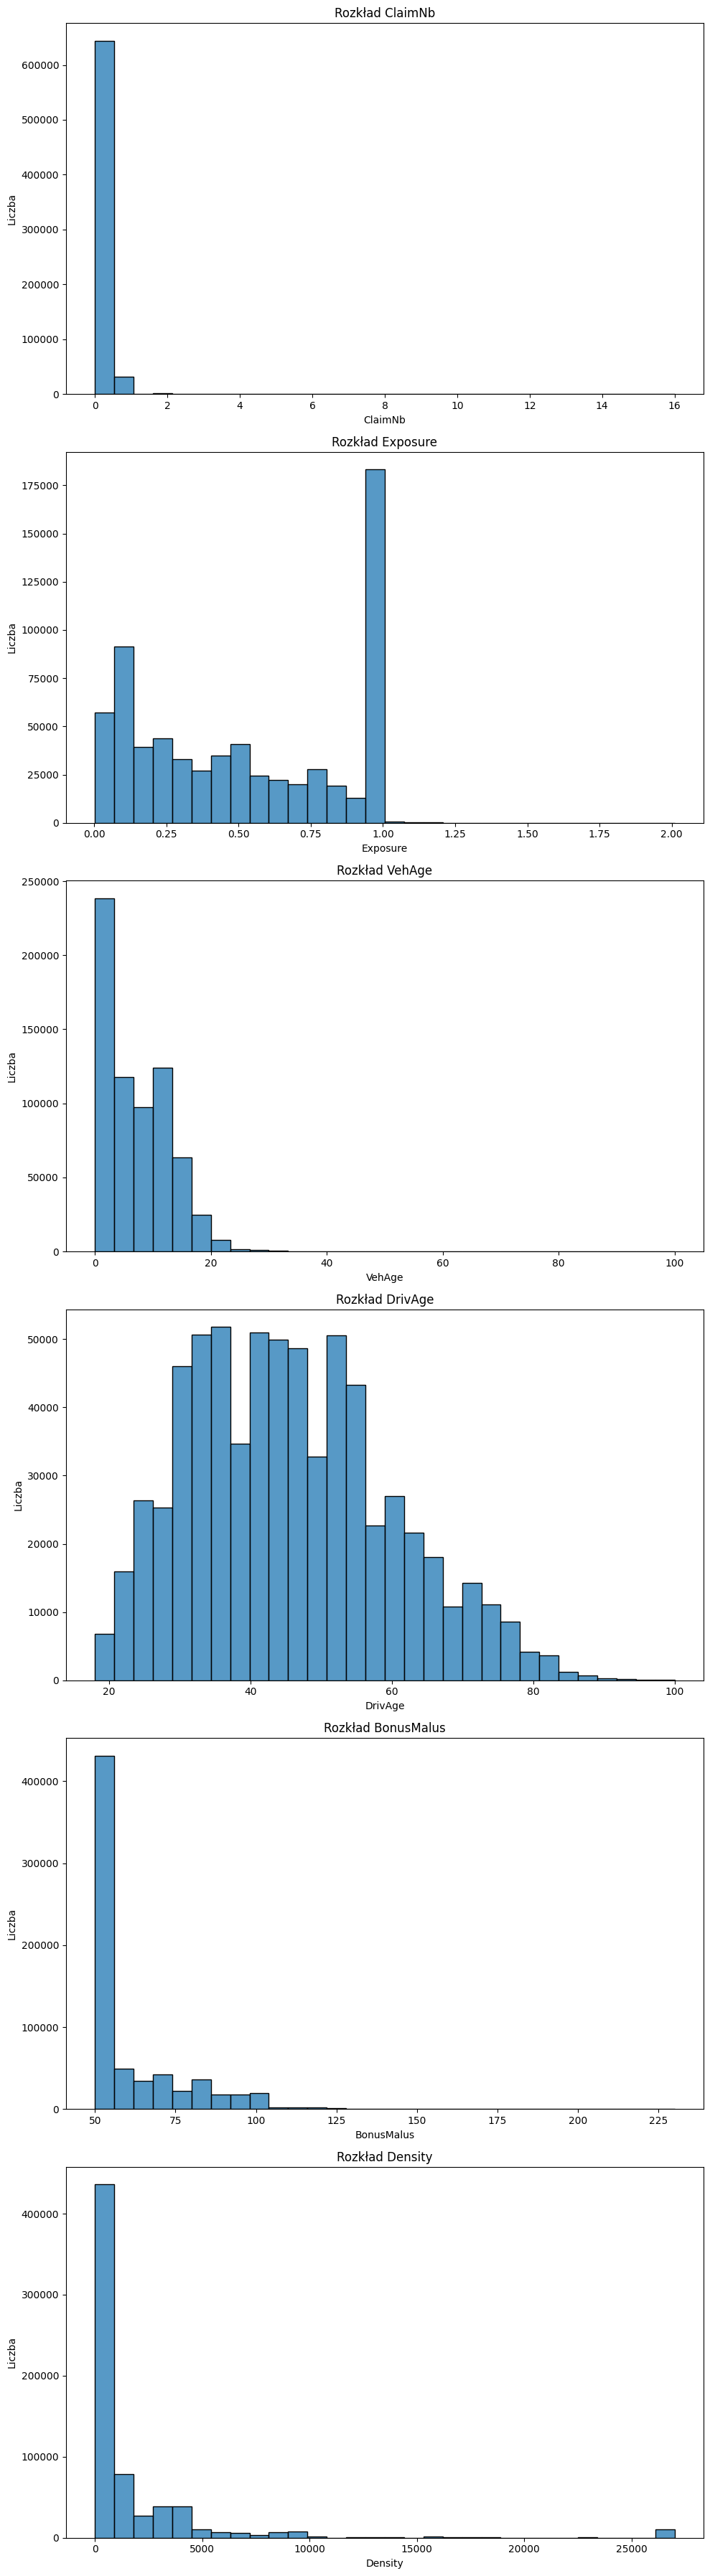

In [38]:
# wykresy rozkładów zmiennych
num_cols = df_freq.select_dtypes(include=[np.number]).columns
plt.figure(figsize=(10, 6 * len(num_cols)))

for i, col in enumerate(num_cols):
    plt.subplot(len(num_cols), 1, i + 1)
    sns.histplot(data=df_freq, x=col, bins=30)
    plt.title(f"Rozkład {col}")
    plt.xlabel(col)
    plt.ylabel("Liczba")
    
plt.tight_layout()
plt.show()

In [46]:
df_freq[df_freq["VehAge"] > 24.5]["VehAge"].count()

np.int64(3114)

In [66]:
# liczba samochodów w wieku powyżej 24.5
temp = df_freq[df_freq["VehAge"] > 24.5].groupby("VehAge").size().reset_index(name="count")
# sns.barplot(data=temp, x="VehAge", y="count")
temp

,VehAge,count
0,25,495
1,26,369
2,27,326
3,28,278
4,29,281
5,30,249
6,31,217
7,32,153
8,33,124
9,34,103


In [40]:
# number of peolpe at given age
df_freq[df_freq["DrivAge"] > 86.5].groupby("DrivAge")["DrivAge"].count()

DrivAge
87     280
88     229
89     198
90     167
91     121
92      66
93      55
94      32
95      24
96      15
97      10
98       5
99      70
100      3
Name: DrivAge, dtype: int64

Istnieje kilka wartości, które można zaklasyfikować jako wartości odstające zarówno w przypadku wieku kierowcy, jak i wieku pojazdu, w oparciu o metody ilościowe i ekspertyzę. Dlatego potraktuję je jako wartości brakujące i uzupełnię te wartości przy użyciu odpowiedniej metody imputacji.

In [41]:
# sprawdzenie obszarów i regionów o najwyższej gęstości 
area_var = ["Area", "Region"]
for col in area_var:
    print(df_freq[df_freq["Density"] >= 27000][col].unique())

['F']
['R11']


In [42]:
# sprawdzenie różnorodności gęstościw regionie i obszarze o największej gęstości
df_freq[(df_freq["Area"] == "F") & (df_freq["Region"] == "R11")]\
    .groupby("Density")["Density"]\
    .count()\
    .sort_values(ascending=False)

Density
27000    10515
17140      910
10156      816
16533      613
15703      557
15725      526
22669      463
10477      344
12374      296
14368      285
12750      225
10155      202
18229      200
16284      194
22821      182
16291      175
10068      171
10961      165
13520      158
12650      154
15386      145
10008      144
13719      119
14200      109
21410       76
12437       70
16052       68
23396       66
20000        6
Name: Density, dtype: int64

Gęstość wynosząca 27000 osób na km kwadratowy wydaje się nieco dziwna, ale nie ma podstaw, aby zajmować się tą wartością, ponieważ występuje ona tylko w regionie 11, obszarze F, a ponadto jest to najczęściej występująca wartość gęstości w tym miejscu.

In [43]:
# explorying claim number distribution
df_freq[df_freq["ClaimNb"] > 0].groupby("ClaimNb").agg({"ClaimNb":"count", "Exposure":"mean"})

,ClaimNb,Exposure
ClaimNb,,
1,32178,0.642388
2,1784,0.646535
3,82,0.643415
4,7,0.438571
5,2,0.540000
6,1,0.330000
8,1,0.410000
9,1,0.080000
11,3,0.383333


In [44]:
df_freq[df_freq["ClaimNb"].isin([9, 11, 16])]

,ClaimNb,Exposure,Area,VehPower,VehAge,DrivAge,BonusMalus,VehBrand,VehGas,Density,Region
6539,11,1.00,A,5,6,65,50,B2,Diesel,13,R24
321248,16,0.33,D,4,12,52,50,B1,Regular,824,R91
321512,9,0.08,D,4,12,52,50,B1,Regular,824,R91
487268,11,0.08,D,4,13,53,50,B1,Regular,824,R91
488270,11,0.07,D,4,13,53,50,B1,Regular,824,R91


Najwyższe wartości liczby roszczeń wyglądają bardzo podejrzanie, zwłaszcza biorąc pod uwagę okres narażenia. Na przykład bardzo mało prawdopodobne jest, aby w ciągu miesiąca zgłoszono 9 roszczeń.

Strategia usuwania wartości odstających:
- w przypadku wieku kierowcy i wieku pojazdu usunę wartości powyżej 25 i 87 i zastąpię je z wykorzystaniem algorytmu KNN.
- w przypadku liczby roszczeń nie mogę zastosować tej samej strategii, ponieważ obserwacji dotyczących roszczeń jest bardzo niewiele. Dlatego też ustalę limit roszczeń na 5 i zmienię wszystkie wartości powyżej 5 na 5.

In [22]:
df_freq["DrivAge"] = df_freq["DrivAge"].where(~(df_freq["DrivAge"] > 87), np.nan)
df_freq["VehAge"] = df_freq["VehAge"].where(~(df_freq["VehAge"] > 25), np.nan)

In [23]:
# encoding and scaling categorical variables for the purpose of imputation
to_encode = df_freq[categorical]

ohe = OneHotEncoder(sparse_output=False, drop="first")

encoded_array = ohe.fit_transform(to_encode)
encoded_df = pd.DataFrame(encoded_array, columns=ohe.get_feature_names_out(to_encode.columns))
df_final = pd.concat([df_freq[numerical], encoded_df], axis=1)

scaler = StandardScaler()
df_final[numerical] = scaler.fit_transform(df_final[numerical])

df_final

,ClaimNb,Exposure,VehPower,VehAge,DrivAge,BonusMalus,Density,Area_B,Area_C,Area_D,...,Region_R53,Region_R54,Region_R72,Region_R73,Region_R74,Region_R82,Region_R83,Region_R91,Region_R93,Region_R94
0,3.943000,-1.176453,-0.709264,-1.286082,0.681462,-0.624273,-0.145363,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,3.943000,0.661979,-0.709264,-1.286082,0.681462,-0.624273,-0.145363,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,3.943000,0.607100,-0.221676,-0.915708,0.467785,-0.624273,-0.439148,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,3.943000,0.854054,0.265912,-1.286082,0.040430,-0.624273,-0.433591,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,3.943000,-0.024003,-0.221676,-0.915708,-0.529377,-0.624273,0.305799,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
677997,-0.221744,-1.443328,-1.196852,-1.286082,0.610237,-0.624273,0.385118,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
677998,-0.221744,-1.443328,-1.196852,-1.286082,-0.315700,2.253570,2.035420,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
677999,-0.221744,-1.443328,-0.221676,-0.915708,-0.030796,-0.624273,-0.118586,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
678000,-0.221744,-1.443328,-1.196852,-1.286082,1.037592,-0.624273,-0.428791,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [26]:
# Training imputer and saving results
# %%script false
imputer_age = KNNImputer()
imputed_array = imputer_age.fit_transform(df_final)
with open('imputed_array_age.npy', "wb") as f:
    np.save(f, imputed_array)

In [27]:
# Loading results of imputation model and reversing transformations: encoding and scaling
with open("imputed_array_age.npy", "rb") as f:
    imputed_array = np.load('imputed_array_age.npy')

df_full = pd.DataFrame(imputed_array, columns=df_final.columns)
decoded_array = ohe.inverse_transform(df_full[encoded_df.columns])
decoded_df = pd.DataFrame(decoded_array, columns=categorical)
df_full[numerical] = scaler.inverse_transform(df_full[numerical])
df_full = pd.concat([df_full[numerical], decoded_df], axis=1)

df_full

,ClaimNb,Exposure,VehPower,VehAge,DrivAge,BonusMalus,Density,Area,VehBrand,VehGas,Region
0,1.0,0.10000,5.0,0.0,55.0,50.0,1217.0,D,B12,Regular,R82
1,1.0,0.77000,5.0,0.0,55.0,50.0,1217.0,D,B12,Regular,R82
2,1.0,0.75000,6.0,2.0,52.0,50.0,54.0,B,B12,Diesel,R22
3,1.0,0.84000,7.0,0.0,46.0,50.0,76.0,B,B12,Diesel,R72
4,1.0,0.52000,6.0,2.0,38.0,50.0,3003.0,E,B12,Regular,R31
...,...,...,...,...,...,...,...,...,...,...,...
677997,0.0,0.00274,4.0,0.0,54.0,50.0,3317.0,E,B12,Regular,R93
677998,0.0,0.00274,4.0,0.0,41.0,95.0,9850.0,E,B12,Regular,R11
677999,0.0,0.00274,6.0,2.0,45.0,50.0,1323.0,D,B12,Diesel,R82
678000,0.0,0.00274,4.0,0.0,60.0,50.0,95.0,B,B12,Regular,R26


In [28]:
# adding cap on claim numbers
df_full["ClaimNb"] = df_full["ClaimNb"].where(~(df_full["ClaimNb"] > 5), 5)

In [29]:
# Creating claim frequency feature
df_full["ClaimFrequency"] = df_full["ClaimNb"]/df_full["Exposure"]

In [30]:
# after cleaning data exploration
df_full.describe()

,ClaimNb,Exposure,VehPower,VehAge,DrivAge,BonusMalus,Density,ClaimFrequency
count,678002.000000,678002.000000,678002.000000,678002.000000,678002.000000,678002.000000,678002.000000,678002.000000
mean,0.053189,0.528748,6.454637,6.956276,45.442614,59.761574,1792.442657,0.263563
std,0.238196,0.364441,2.050914,5.398480,14.037434,15.636724,3958.673690,4.586582
min,0.000000,0.002732,4.000000,0.000000,18.000000,50.000000,1.000000,0.000000
25%,0.000000,0.180000,5.000000,2.000000,34.000000,50.000000,92.000000,0.000000
50%,0.000000,0.490000,6.000000,6.000000,44.000000,50.000000,393.000000,0.000000
75%,0.000000,0.990000,7.000000,11.000000,55.000000,64.000000,1658.000000,0.000000
max,5.000000,2.010000,15.000000,25.000000,87.000000,230.000000,27000.000000,732.000000


After cleaning the data and adding the claim frequency feature, the dataset is much closer to what we expect before exploratory data analysis. However, the maximum claim frequency value of 732 seems incorrect and requires further investigation for a better understanding.

In [31]:
# checking details of exposure for frequency higher than available claim number
df_full[df_full["ClaimFrequency"] > 5]["Exposure"].describe()

count    5471.000000
mean        0.101990
std         0.069547
min         0.002732
25%         0.050000
50%         0.090000
75%         0.140000
max         0.570000
Name: Exposure, dtype: float64

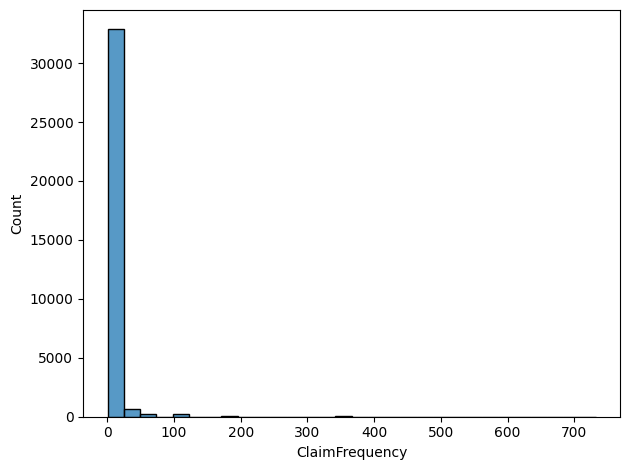

In [32]:
# histogram of claim freqency above 0
sns.histplot(data=df_full[df_full["ClaimFrequency"] > 0], x="ClaimFrequency", bins=30)
plt.tight_layout()
plt.show()

Claim frequencies in the hundreds are suspicious and highly unlikely. The reason for their occurrence is likely a claim during a very short exposure period. To make these values more realistic, I will change the denominator of the claim frequency to 1 (the median) for cases where the exposure period is below a quarter (0.25).

In [33]:
# claim frequency recalculation
df_full["ClaimFrequency"] = df_full["ClaimNb"]/df_full["Exposure"].apply(lambda x: x if x >= 0.25 else 1)

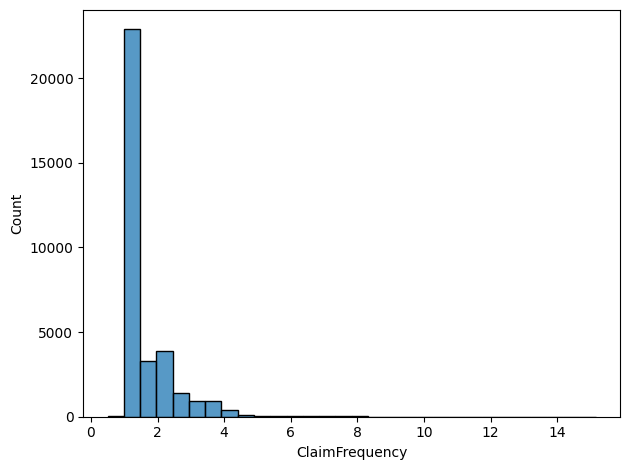

In [34]:
sns.histplot(data=df_full[df_full["ClaimFrequency"] > 0], x="ClaimFrequency", bins=30)
plt.tight_layout()
plt.show()

In [35]:
# explorying highest values of claim frequency
df_full[df_full["ClaimFrequency"] > 14]

,ClaimNb,Exposure,VehPower,VehAge,DrivAge,BonusMalus,Density,Area,VehBrand,VehGas,Region,ClaimFrequency
304474,5.0,0.33,4.0,12.0,52.0,50.0,824.0,D,B1,Regular,R91,15.151515
321238,5.0,0.33,4.0,12.0,52.0,50.0,824.0,D,B1,Regular,R91,15.151515
364427,4.0,0.27,5.0,9.0,23.0,90.0,6924.0,E,B3,Diesel,R11,14.814815


To summarize the loading and cleaning process, the data was loaded, and additional commas were handled. I checked for both missing values and outliers, addressing them based on real-world knowledge and logic. Finally, I added ClaimFrequency as our dependent variable. I am now ready to conduct exploratory data analysis.

In [36]:
df_full.to_csv("cleaned_data.csv", index=False)